In [1]:
import sys
sys.path.append(r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis")

In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


In [4]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 1 # number of HPO iterations for final modeling run

# data import and feature selection
import ==> folder;
data cleaning ==> exclude 方差太小的特征，imputation, exclude the feature with too many 缺失
select_features ==> unsupervised，laplacian score low, highly similar features(person>0.9, optional) are deleted
transformation==> standardize(z-score) / min_max
 或 'gene_id'，取决于你的数据格式

In [7]:
# real data organize

# data prepare
# data import LCMS, HDF

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns


# 1. 指定存放原始与新文件的文件夹
load_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\preprocessed data"

# 3. after sample alignment
HDF = pd.read_csv(os.path.join(load_path, "S_HDF.csv"), index_col=0)
LD  = pd.read_csv(os.path.join(load_path, "S_LD.csv"),  index_col=0)
PM  = pd.read_csv(os.path.join(load_path, "S_PM.csv"),  index_col=0)
BM  = pd.read_csv(os.path.join(load_path, "S_BM.csv"),  index_col=0)

# metadata import
# female=1, male=0
# diabetic=1, nondiabetic=0
metadata = pd.read_excel(r"C:\Users\laura\OneDrive - Imperial College London\project 2\sample data.xlsx")

metadata['SampleId'] = metadata['SampleId'].astype(int)
HDF.index = HDF.index.astype(int)

merged_df = HDF.merge(
    metadata[['SampleId', 'SEX', 'DIAB', 'AGE', 'BMI']],
    left_index=True,
    right_on='SampleId'
)

merged_df['SEX_num'] = merged_df['SEX'].str.strip().str.lower().map({'female': 1, 'male': 0})
merged_df['DIAB_num'] = merged_df['DIAB'].str.strip().str.lower().map({'diabetic': 1, 'non-diabetic': 0})
print("Unmatched SEX values:", merged_df['SEX_num'].isna().sum())
print("Unmatched DIAB values:", merged_df['DIAB_num'].isna().sum())

y_dm = merged_df['DIAB_num']# diabetic=1, nondiabetic=0

# index alignment check
print(f"HDF shape: {HDF.shape}")
print(f"LD shape: {LD.shape}")
print(f"PM shape: {PM.shape}")
print(f"BM shape: {BM.shape}")


# Train-test split
y_dm.index = HDF.index
HDF_train, HDF_test, y_train, y_test = train_test_split(HDF, y_dm, test_size=0.3, random_state=42)
# Split LD, PM, BM using the same indices as HDF
LD_train = LD.loc[HDF_train.index]
LD_test  = LD.loc[HDF_test.index]

PM_train = PM.loc[HDF_train.index]
PM_test  = PM.loc[HDF_test.index]

BM_train = BM.loc[HDF_train.index]
BM_test  = BM.loc[HDF_test.index]

Y_train = y_dm.loc[HDF_train.index]
Y_test  = y_dm.loc[HDF_test.index]

print("train HDF shape:", HDF_train.shape)
print("test HDF shape:", HDF_test.shape)
print("train y_dm shape", y_train.shape)
print("test y_dm shape:", y_test.shape)
print("LD_train shape:", LD_train.shape)
print("LD_test shape:", LD_test.shape)
print("PM_train shape:", PM_train.shape)
print("PM_test shape:", PM_test.shape)
print("BM_train shape:", BM_train.shape)
print("BM_test shape:", BM_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

Unmatched SEX values: 0
Unmatched DIAB values: 0
HDF shape: (282, 904)
LD shape: (282, 1149)
PM shape: (282, 501)
BM shape: (282, 161)
train HDF shape: (197, 904)
test HDF shape: (85, 904)
train y_dm shape (197,)
test y_dm shape: (85,)
LD_train shape: (197, 1149)
LD_test shape: (85, 1149)
PM_train shape: (197, 501)
PM_test shape: (85, 501)
BM_train shape: (197, 161)
BM_test shape: (85, 161)
Y_train shape: (197,)
Y_test shape: (85,)


In [9]:
import os

base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1"

train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# 训练集保存函数
def save_train(df, suffix, filename):
    df.columns = df.columns.astype(str) + f"_{suffix}"        # 样本ID加后缀
    df.index = df.index.astype(str).map(lambda x: "ID_" + x)  # 特征名加前缀
    df_t = df.T
    # 直接保存，保持行索引（样本ID）为CSV的索引
    df_t.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

# 测试集保存函数
def save_test(df, suffix, filename):
    df.columns = df.columns.astype(str) + f"_{suffix}"
    df.index = df.index.astype(str).map(lambda x: "ID_" + x)
    df_t = df.T
    df_t.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)

# 临床训练数据保存
def save_clinical_train(series, filename):
    series = series.replace({0: 'nonDM', 1: 'DM'})
    df = series.to_frame(name='clin')
    df.index = df.index.astype(str).map(lambda x: "ID_" + x)
    df.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

# 临床测试数据保存
def save_clinical_test(series, filename):
    series = series.replace({0: 'nonDM', 1: 'DM'})
    df = series.to_frame(name='clin')
    df.index = df.index.astype(str).map(lambda x: "ID_" + x)
    df.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)


# 保存训练集
save_train(LD_train, "LD", "LD")
save_train(PM_train, "PM", "PM")
save_train(BM_train, "BM", "BM")
save_train(HDF_train, "HDF", "HDF")
save_clinical_train(Y_train, "clin")

# 保存测试集
save_test(LD_test, "LD", "LD")
save_test(PM_test, "PM", "PM")
save_test(BM_test, "BM", "BM")
save_test(HDF_test, "HDF", "HDF")
save_clinical_test(Y_test, "clin")

print(" 所有文件已保存完毕，样本ID加后缀，特征名加前缀，索引正确保存。")


 所有文件已保存完毕，样本ID加后缀，特征名加前缀，索引正确保存。


In [11]:
import pandas as pd
import os

base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

# 文件列表和对应变量名
file_varnames = ["LD", "PM", "BM", "HDF", "clin"]

# 读取训练集
for name in file_varnames:
    path = os.path.join(train_path, f"{name}.csv")
    if name == "clin":
        globals()[f"{name}_train"] = pd.read_csv(path, index_col=0)
    else:
        globals()[f"{name}_train"] = pd.read_csv(path)

# 读取测试集
for name in file_varnames:
    path = os.path.join(test_path, f"{name}.csv")
    if name == "clin":
        globals()[f"{name}_test"] = pd.read_csv(path, index_col=0)
    else:
        globals()[f"{name}_test"] = pd.read_csv(path)


In [13]:
clin_train

,clin
ID_225,nonDM
ID_68,nonDM
ID_138,DM
ID_282,DM
ID_50,nonDM
...,...
ID_240,nonDM
ID_88,DM
ID_133,DM
ID_360,DM


In [15]:
import inspect
from flexynesis import DataImporter

print(inspect.getfile(DataImporter))

from flexynesis import DataImporter

data_importer = DataImporter(
    path=r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1",
    data_types=['LD', 'PM', 'BM', 'HDF'],  # 四个数据集的名称，要和文件名对应
    concatenate=False,  # 根据你需求决定是否合并特征，通常False
    top_percentile=100,  # Laplacian选出前10%特征
    min_features=100,   # 至少保留100个特征
    variance_threshold=0.0,  # 80%的方差阈值
    # correlation_threshold=0.9,  # 如果需要可以打开
)

train_dataset, test_dataset = data_importer.import_data()



C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\data.py

[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\LD.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\PM.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\clin.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\HDF.csv...
[INFO] Importing C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM1\train\BM.csv...

[INFO] ------------

# How does the data looks like in flexynesis dataset

In [18]:
print("===========The way to visit shaoe of dataframe=========")
print(train_dataset.dat['HDF'].shape)  # 输出你的 HDF 数据矩阵形状
print(train_dataset.dat['BM'].shape)  

print("============Visit sample label===========")
print(train_dataset.ann)

print("============How the index and columns are stored=========")
print(train_dataset.samples[1:10], train_dataset.features)

print("============summary of ech block & metadata==================")
print(train_dataset.dat)
flexynesis.print_summary_stats(train_dataset)

===========The way to visit shaoe of dataframe=========
torch.Size([197, 904])
torch.Size([197, 161])
============Visit sample label===========
{'clin': tensor([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,

# Training flexynesis models

## input _init_()
* dataset: the training dataset (as we constructed above)
* model_class: which model architecture to use:
    a) DirectPred: a fully connected network (standard multilayer perceptron) with supervisor heads (one MLP for each target variable) 
    b) Supervised Variational Autoencoder: A variational autoencoder (MMD-loss) with supervisor heads (one MLP for each target variable) 
    c) MultiTripletNetwork: A network structured in triplets to enable contrastive learning (using triplet loss) and additiona supervisor heads (one MLP for each target variable)
* target_variables: A comma separated list of target variables (specify the column headers from the clin.csv). One MLP per each target variable will be created.
The target variables may contain NA values
* config_name: which hyperparameter search space configuration to use.
* n_iter: How many hyperparameter search steps to implement.
简单说明： 尝试不同的超参数组合（n_iter），返回表现最好的模型

## HPO & fine-tuning to train paremeters
using  basiyan  optimizer to search the best paremeter
using objective(loss function) to assess the performance
allow early stopping to speed up the searching(hpo_patience)
* loss function:
          y_hat = outputs[var]           y = y_dict[var]
          loss = self.compute_loss(var, y, y_hatn* fine-tuning: g
using K-fold validation , using different learning rate and freeze different parts

## DirectPred modeg


In [21]:
print(inspect.getfile(flexynesis.HyperparameterTuning.perform_tuning))
print(inspect.getfile(flexynesis.models.direct_pred.DirectPred))

C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\main.py
C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\models\direct_pred.py


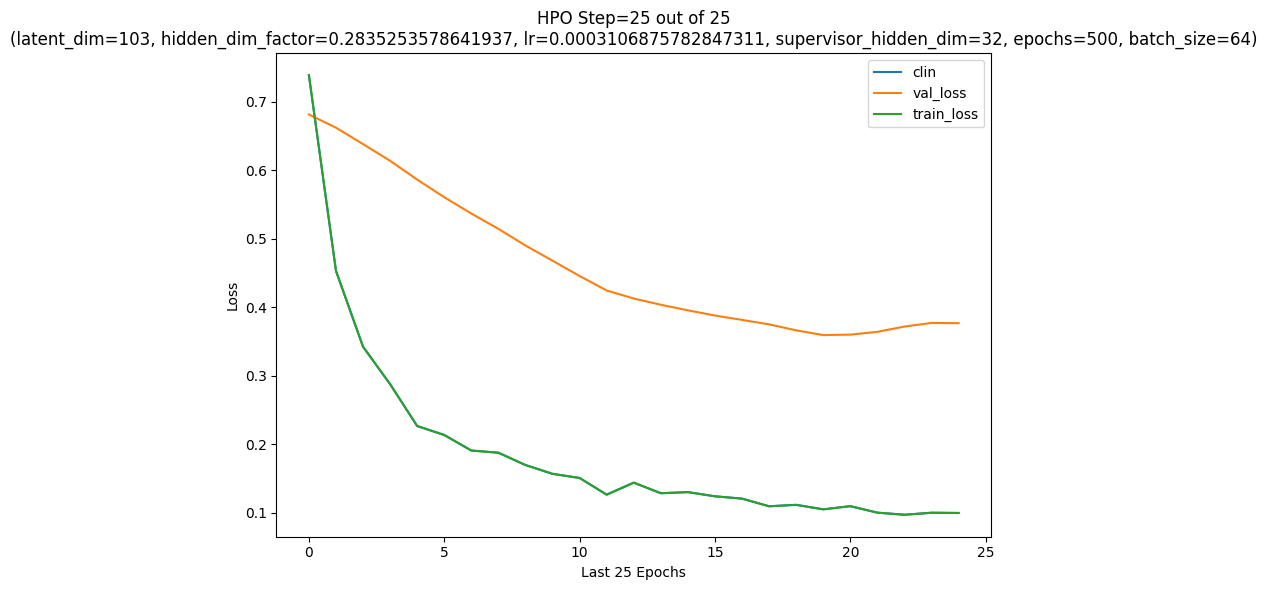

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.3766404688358307     │
│         val_loss          │    0.3766404688358307     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 25/25 [1:30:58<00:00, 218.33s/it, Iteration=25, Best Loss=0.322]

[INFO] current best val loss: 0.32173243165016174; best params: {'latent_dim': 28, 'hidden_dim_factor': 0.2, 'lr': 0.005964458198037307, 'supervisor_hidden_dim': 14, 'epochs': 500, 'batch_size': 64} since 4 hpo iterations


In [39]:
# early stopping -  tune the best parameters
tuner = flexynesis.HyperparameterTuning(
    dataset = train_dataset,                # 训练用的数据集
    model_class = flexynesis.DirectPred,   # 用哪种模型结构，这里是简单的全连接网络
    target_variables = ["clin"],# 你想预测哪个变量
    config_name = "DirectPred",             # 调参用的配置名称（超参数空间）
    n_iter=25,                              # 只跑1次超参数搜索（调1组参数）
    plot_losses=True,                      # 打开训练过程的loss打印
    early_stop_patience=5                 # 如果10轮没改进，就停训练
)

model, best_params = tuner.perform_tuning()  # 执行超参数调优，返回最佳模型和参数


In [41]:
model

DirectPred(
  (log_vars): ParameterDict(  (clin): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=1149, out_features=229, bias=True)
      (layer_out): Linear(in_features=229, out_features=28, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(229, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=161, out_features=32, bias=True)
      (layer_out): Linear(in_features=32, out_features=28, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MLP(
      (layer_1): Linear(in_features=501, out_features=100, bias=True)
      (layer_out): Linear(in_features=100, out_features=28, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace

In [43]:
best_params

{'latent_dim': 28,
 'hidden_dim_factor': 0.2,
 'lr': 0.005964458198037307,
 'supervisor_hidden_dim': 14,
 'epochs': 29,
 'batch_size': 64}

In [47]:
import os
import json
import torch

prefix = "4 blocks_model"  # 这里写你自己定义的名字
save_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\models\model parameters"

filename = f"{prefix}_final_model.pth"
save_path = os.path.join(save_dir, filename)

# 保存模型
torch.save(model, save_path)

import numpy as np

# 假设 best_params 是 dict，里面有 numpy 类型
def convert_numpy_types(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(i) for i in obj]
    elif isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, (np.floating,)):
        return float(obj)
    else:
        return obj

best_params_clean = convert_numpy_types(best_params)

with open(best_params_path, 'w') as f:
    json.dump(best_params_clean, f)


NameError: name 'best_params_path' is not defined

In [21]:
import torch
import json
import os

model_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\models\model parameters\4 blocks_model_final_model.pth"
model = torch.load(model_path, weights_only=False)
model.eval()  # 切换到评估模式（如果有必要）

DirectPred(
  (log_vars): ParameterDict(  (clin): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=161, out_features=47, bias=True)
      (layer_out): Linear(in_features=47, out_features=21, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(47, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=904, out_features=267, bias=True)
      (layer_out): Linear(in_features=267, out_features=21, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(267, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MLP(
      (layer_1): Linear(in_features=1149, out_features=339, bias=True)
      (layer_out): Linear(in_features=339, out_features=21, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace

# Prediction and model evaluation

In [49]:
y_pred_dict = model.predict(test_dataset)
y_pred_dict

{'clin': array([[3.33125830e-01, 6.66874170e-01],
        [3.66168141e-01, 6.33831859e-01],
        [9.43857610e-01, 5.61423786e-02],
        [8.10649157e-01, 1.89350814e-01],
        [9.61455047e-01, 3.85449342e-02],
        [9.91249204e-01, 8.75073392e-03],
        [9.84814525e-01, 1.51853962e-02],
        [9.52411950e-01, 4.75880243e-02],
        [6.71934262e-02, 9.32806551e-01],
        [1.46644993e-03, 9.98533487e-01],
        [1.47662626e-03, 9.98523414e-01],
        [9.99532342e-01, 4.67651553e-04],
        [1.08216638e-02, 9.89178300e-01],
        [7.44778803e-03, 9.92552280e-01],
        [1.51700643e-03, 9.98483002e-01],
        [9.65035737e-01, 3.49643044e-02],
        [9.60805237e-01, 3.91947553e-02],
        [9.89730954e-01, 1.02690337e-02],
        [6.59579877e-03, 9.93404210e-01],
        [2.09474517e-03, 9.97905254e-01],
        [5.94030917e-01, 4.05969083e-01],
        [3.91861744e-04, 9.99608219e-01],
        [9.81374085e-01, 1.86259691e-02],
        [8.88768137e-01, 1

In [51]:
print(inspect.getfile(flexynesis.evaluate_wrapper))

C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\flexynesis\utils.py


In [53]:
metrics_df = flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=y_pred_dict, dataset = test_dataset)
metrics_df
# 函数的逻辑是如果是数值型就使用生存分析或者回归分析，但是我们的0和1其实是分类的变量。
# Modify the evaluate_wrapper to get more metrix

⚠️ Warning: All variables are forcibly treated as categorical during evaluation.


,method,var,variable_type,metric,value
0,DirectPred,clin,categorical,balanced_acc,0.916109
1,DirectPred,clin,categorical,f1_score,0.917555
2,DirectPred,clin,categorical,kappa,0.833845
3,DirectPred,clin,categorical,average_auroc,0.965998
4,DirectPred,clin,categorical,average_aupr,0.955006


In [33]:
# feature importance

In [45]:
import inspect
inspect.getfile(model.compute_feature_importance)

'C:\\Users\\laura\\OneDrive - Imperial College London\\project 2\\Coding\\New models\\package\\flexynesis\\flexynesis\\models\\direct_pred.py'

In [ ]:
# Visualizing the sample embeddings

'C:\\Users\\laura\\OneDrive - Imperial College London\\project 2\\Coding\\New models\\package\\flexynesis\\flexynesis\\utils.py'

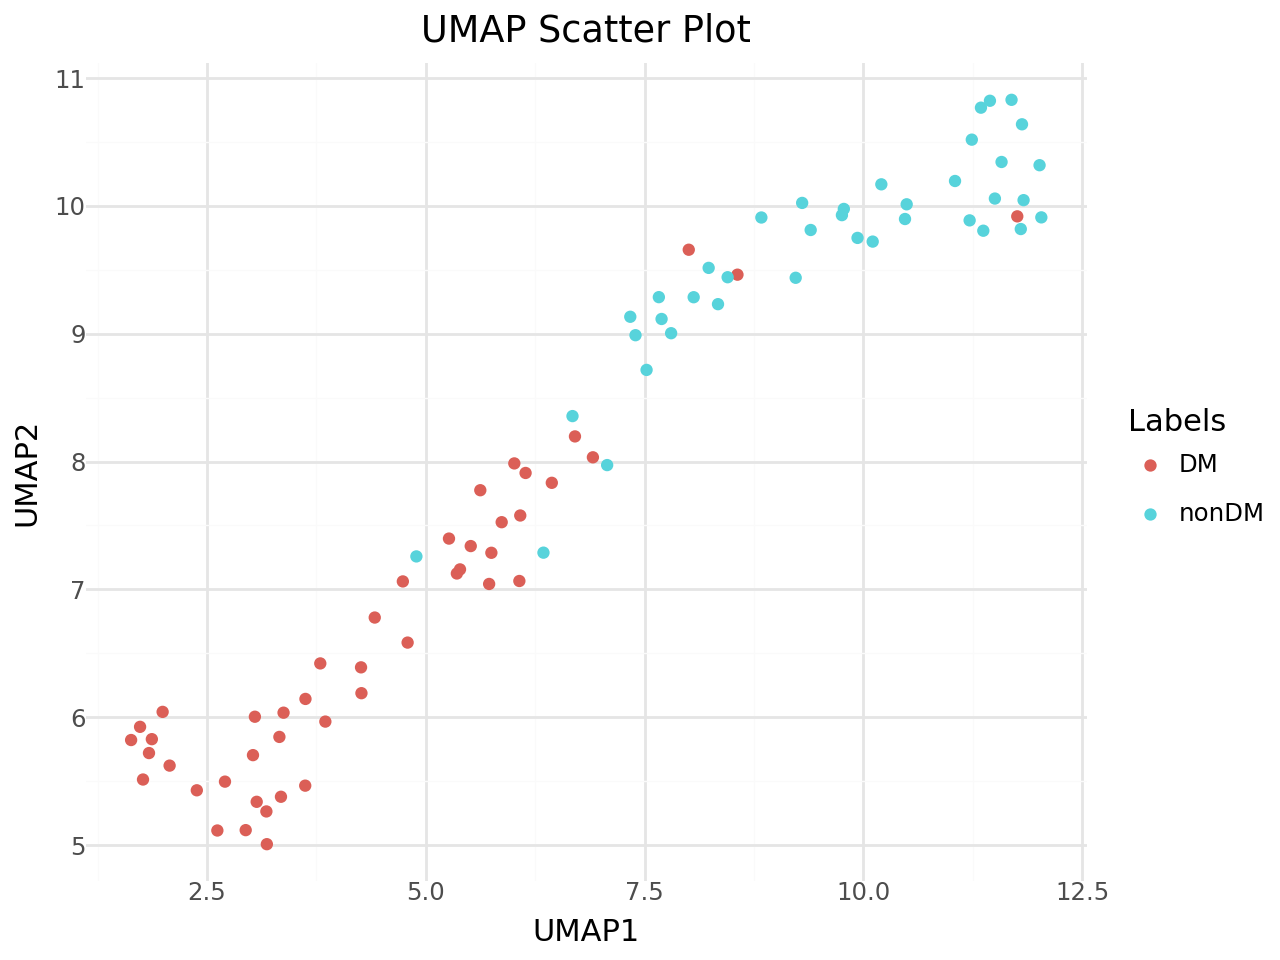

In [49]:
import inspect
inspect.getfile(flexynesis.plot_dim_reduced)

ds = test_dataset
E = model.transform(ds)
E.head()

f = 'clin'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] #map the sample labels from numeric vector to initial labels. 

# flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='pca')
flexynesis.plot_dim_reduced(E, labels, color_type = 'categorical', method='umap')

In [ ]:
flexynesis.compute_feature_importance

self, dataset, target_var, method="IntegratedGradients", steps_or_samples=5, batch_size=64

plot_dim_reduced(matrix, labels, method='pca', color_type='categorical', title=None)

In [55]:

feature_importance= model.compute_feature_importance(
    dataset=test_dataset,
    target_var="clin",
    method="GradientShap",       #  这里你选择 GradientShap
    steps_or_samples=10,         # 可选，控制精度，默认是 5
    batch_size=32                # 可选，默认是 64
)

In [57]:
feature_importance

,target_variable,target_class,target_class_label,layer,name,importance
0,clin,0,DM,LD,CE(12:0)_LD,0.000645
1,clin,0,DM,LD,CE(14:0)_LD,0.000595
2,clin,0,DM,LD,CE(14:1)_LD,0.001085
3,clin,0,DM,LD,CE(15:0)_LD,0.000791
4,clin,0,DM,LD,CE(16:0)_LD,0.001700
...,...,...,...,...,...,...
5425,clin,1,nonDM,HDF,HDF62636_HDF,0.007895
5426,clin,1,nonDM,HDF,HDF62664_HDF,0.016435
5427,clin,1,nonDM,HDF,HDF62716_HDF,0.005616
5428,clin,1,nonDM,HDF,HDF62719_HDF,0.008436


  target_variable  target_class target_class_label layer         name  \
0            clin             0                 DM    LD  CE(12:0)_LD   
1            clin             0                 DM    LD  CE(14:0)_LD   
2            clin             0                 DM    LD  CE(14:1)_LD   
3            clin             0                 DM    LD  CE(15:0)_LD   
4            clin             0                 DM    LD  CE(16:0)_LD   

   importance  
0    0.000645  
1    0.000595  
2    0.001085  
3    0.000791  
4    0.001700  
